In [44]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [45]:

# Get the list of S&P 500 constituents
tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)


[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [46]:
sp500.tail(1) #Adjusted Close

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-12 00:00:00,128.919998,14.125,194.259995,153.240005,141.009995,106.940002,80.275002,342.01001,630.52002,190.240005,...,86.25,61.07,97.985001,31.855,108.440002,127.629997,117.305,240.934998,38.310001,191.455002


### Im using lagged close_price to get the adjusted close of the time period accounting for 20 day lag. The rolling mean price is used for the 52 week trend. It doesnt account for lag, but the calculation will. It gets the rolling mean of the time period into a 252 window. 

In [47]:
# 20 Day lag. Change time_period before running code
time_period = 1260  # 1 year 252, 5 year 1260 
start_period = -20 - time_period
end_period = -20  
lagged_closed_price = sp500[start_period:end_period]
rolling_mean_price = sp500[-time_period:].rolling(window=time_period-252).mean().dropna(how='all')


In [48]:

# Function to calculate momentum factors
def calculate_momentum_factors(tickers, time_period):

    # Calculating 52 Week trend
    slope_info = pd.DataFrame(index = sp500.columns)
    for i in range(1,21):
        slope_info[i] = np.polyfit(range(len(rolling_mean_price[-i- 252: -i ])), rolling_mean_price[-i-252 : -i], 1)[0]  
    _52_week_trend = slope_info.mean(axis=1) 


    # Percent above 260 day Low
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Oscillator calculations
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # 39 week returns
    _39_week_return = lagged_closed_price.pct_change(periods=39*5)
    _39_week_return= _39_week_return.dropna(how='all').mean()    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[start_period:end_period]
    weekly_means = lagged_closed_price.rolling(5).mean()                        # Rolling mean removes a week(5)
    weekly_volume = volume[start_period:end_period].rolling(5).mean()           # Making it 51 week
    volume_price_trend = (weekly_means.pct_change() * weekly_volume).mean()
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = _39_week_return
    new_table['51 Week Volume Price Trend'] = volume_price_trend

    return new_table



In [49]:
momentum_factors = calculate_momentum_factors(tickers, time_period)
momentum_factors



,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
A,0.055072,38.382148,7.125966,0.137078,127.288100
AAL,-0.015895,44.122800,-6.909119,-0.051484,61182.414812
AAPL,0.122740,60.663185,15.986626,0.314887,75438.400438
ABBV,0.082660,40.513192,10.745892,0.175105,1099.283056
ABNB,NaN,32.404214,-6.202458,-0.049052,-1820.673380
...,...,...,...,...,...
YUM,0.032792,36.516524,3.358363,0.081347,93.875882
ZBH,0.010914,35.073638,0.689676,0.042391,-742.485812
ZBRA,0.077441,58.096262,4.983993,0.150996,-292.296608
ZION,-0.005830,52.432156,-0.662576,0.032493,-4880.763678


In [50]:
z_scores = (momentum_factors - momentum_factors.mean()) / momentum_factors.std()
z_scores = z_scores.sum(axis=1)



In [51]:
z_scores.sort_values(ascending=False, inplace= True)
long_basket= z_scores[:10]
short_basket = z_scores[-10:]

print("Long Basket:")
print (long_basket)
print("Short Basket:") 
print(short_basket)

Long Basket:
TSLA    43.112659
MRNA    20.350811
ENPH    19.162555
NVDA    16.052076
NVR     15.573304
AMD     10.146412
AZO      9.845765
CMG      9.678539
SEDG     8.229572
FCX      8.150968
dtype: float64
Short Basket:
MMM    -5.289825
BXP    -5.290819
VZ     -5.296504
WBA    -5.517204
BAX    -5.952063
PARA   -6.070260
FIS    -6.116725
WBD    -6.217212
VTRS   -6.572595
VFC    -7.614915
dtype: float64


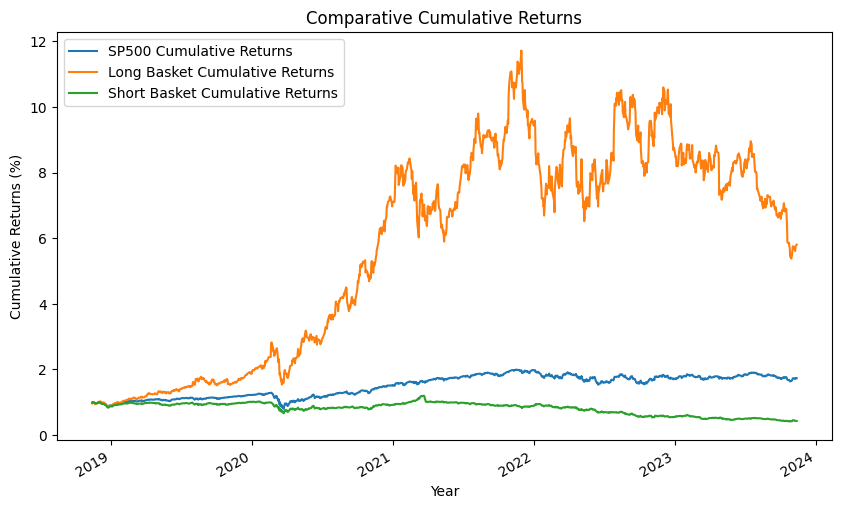

In [52]:
#Back-Test period of time_period year (20 Day Lag)

long_list =long_basket.index
short_list= short_basket.index

long_basket_close =sp500[start_period:end_period][long_list]
short_basket_close =sp500[start_period:end_period][short_list]


# I should make this next part a function, for autonomy
returns = sp500[start_period:end_period].pct_change()
cumulative_returns = (1 + returns).cumprod().mean(axis=1)


long_returns = long_basket_close.pct_change()
long_cumulative_returns = (1+long_returns).cumprod().mean(axis=1)

short_returns = short_basket_close.pct_change()
short_cumulative_returns = (1+short_returns).cumprod().mean(axis=1)



plt.figure(figsize=(10,6))
cumulative_returns.plot(label='SP500 Cumulative Returns')
long_cumulative_returns.plot(label='Long Basket Cumulative Returns')
short_cumulative_returns.plot(label='Short Basket Cumulative Returns')

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()




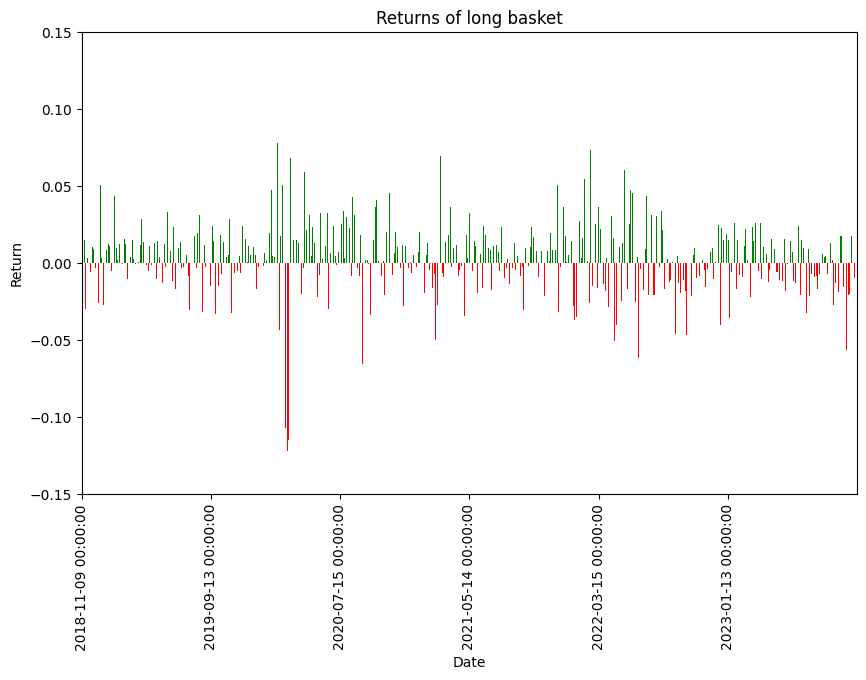

In [105]:
graphing = pd.DataFrame(long_returns.mean(axis=1))
graphing.columns = ['Returns']

colors = ['r' if m < 0 else 'g' for m in graphing.Returns]
graphing.plot.bar(figsize=(10,6), y='Returns',color=colors, legend=False)
plt.locator_params(axis='x', nbins=6)
plt.ylim(-.15,.15)
plt.ylabel('Return')
plt.title('Returns of long basket')
plt.show()



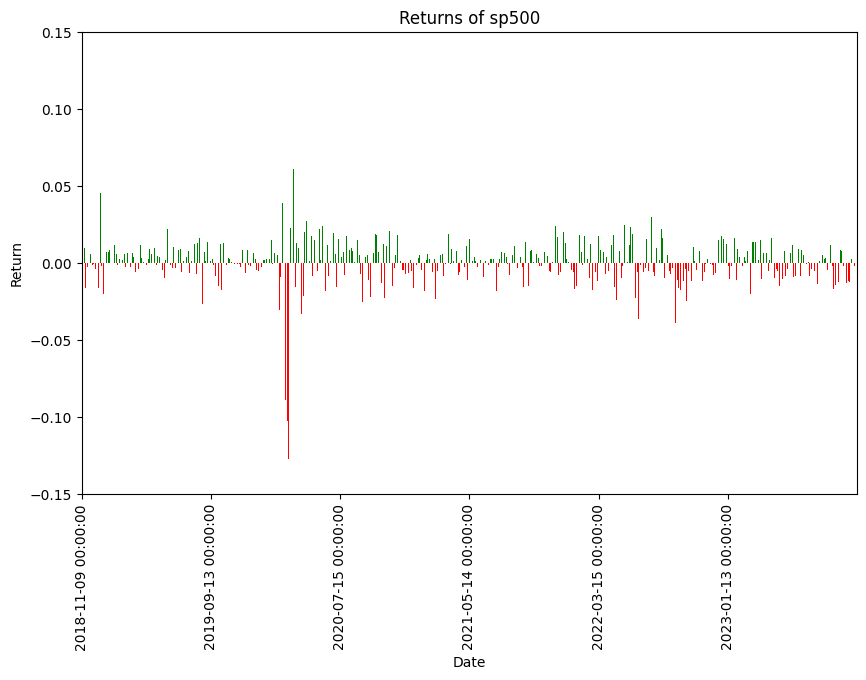

In [106]:
graphing_sp500 = pd.DataFrame(returns.mean(axis=1))
graphing_sp500.columns = ['Returns']

colors = ['r' if m < 0 else 'g' for m in graphing_sp500.Returns]
graphing_sp500.plot.bar(figsize=(10,6), y='Returns',color=colors, legend=False)
plt.locator_params(axis='x', nbins=6)
plt.ylim(-.15,.15)
plt.ylabel('Return')
plt.title('Returns of sp500')
plt.show()